# Pattern recognition on wafer bin maps 

## Task outline
Create an augmented dataset of defects on wafer bin maps and train a map size independent CNN classifier to recognize them. For more information on what a wafer bin map looks like see [link](https://www.icknowledge.com/freecontent/Introduction%20to%20IC%20technology%20rev%205.pdf).


## Introduction
Sources:
- [Wikipedia](https://en.wikipedia.org/wiki/Wafer_(electronics))
- [Mixed Pattern Recognition Methodology on Wafer Maps with Pre-trained Convolutional Neural Networks](https://www.scitepress.org/Papers/2020/91779/91779.pdf)

In electronics, a **wafer** is a **thin slice of semiconductor**, such as a crystalline silicon, **used for the fabrication of integrated circuits** and, in photovoltaics, to manufacture solar cells. The wafer serves as the substrate for microelectronic devices built in and upon the wafer. It undergoes many microfabrication processes, such as doping, ion implantation, etching, thin-film deposition of various materials, and photolithographic patterning. Finally, the individual microcircuits are separated by wafer dicing and packaged as an integrated circuit.

The semiconductor manufacturing process is fine and sophisticated. So, if a problem in any part of the
process occurs, it can be fatal on the **yield** (percentage of the actual number of good chips produced, relative to the maximum number of chips on a wafer).

One way to increase the yield is to **check the defect pattern on wafer bin maps and control the causes of yield degradation**. Wafer bin maps can be obtained during the **EDS (electrical die sorting) test** that checks the quality of each chip on wafers. By testing various parameters such as voltage, current, and temperature, the chips are tagged good or bad. Then, engineers can **identify defect patterns that appear on the map**. Defect patterns contain various type such as **center, donut, scratch, and ring**. Each pattern is related to the **different causal factors**. If the pattern is
exactly identified, it can be **estimated what problem occurs**.

In fact, many engineers **still check the map visually**, so it is difficult to identify many wafers one by one. Also, it is hard to classify the type, especially when the patterns are mixed. It is an **opportunity for automatic classification**. 

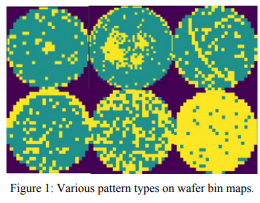

## Data

Our dataset consists of wafer bin maps split into 5 classes labelled
- `clear`   (9999 samples)
- `field`   ( 368 samples)
- `mask`    (2897 samples)
- `probe`   (1080 samples)
- `scratch` ( 129 samples)

Each wafer bin map is stored as a .csv file consisting of 6 values. From observing the data, I've concluded that these values mean:
- -1: `background` -> will be shown as **violet**
- 0: `standard wafer` -> will be shown as **green**
- \> 0: `defects` -> will be shown as values from the *Autumn* colormap (from yellow to dark orange-red)

In [35]:
import cv2
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import shuffle

In [36]:
tf.config.run_functions_eagerly(True)

In [37]:
PATH_DATASET = "/kaggle/input/wafer-bin-maps/data/"
SEED = 42
TEST_SIZE = 0.2
BATCH_SIZE = 256

random.seed(SEED)

### Functions to load and transform data

In [38]:
def load_images_as_df(categories=[], limit=None):
    files_by_categories = {category: [] for category in categories}
    for i, category in enumerate(categories):
        print(f"Loading category {category} ({i + 1}/{len(categories)})")
        filenames = [filename for filename in os.listdir(os.path.join(PATH_DATASET, category)) if filename.endswith(".csv")]
        if limit is not None:
            limit = min(limit, len(filenames))
            filenames = filenames[:limit]
        with tqdm(total=len(filenames)) as pbar:
            for filename in filenames:
                files_by_categories[category].append(pd.read_csv(os.path.join(PATH_DATASET, category, filename)))
                pbar.update()
        print(f"Loaded {len(files_by_categories[category])} dataframes of category {category}.")
    return files_by_categories

In [39]:
def get_color(value, cmap_name="autumn", max_=14):
    if value > max_:
        value = max_
    if value < -0.75:
        return np.array([ 91,  10, 145])  # violet
    elif -0.75 <= value <= 0.5:
        return np.array([  0, 255,   0])  # green
    elif 0.5 < value <= max_:
        cmap = plt.get_cmap(cmap_name)
        color = cmap(value / max_)
        color = np.array(list(color)[:3])
        color *= 255
        color = color.astype(int)
        return color
    else:
        raise ValueError(f"Invalud `value`. Expected <-1, {max_}>, got {value}.")

In [40]:
def transform_csv_to_np(df):
    return df.drop(["Unnamed: 0"], axis=1).values

In [41]:
def transform_csv_to_img(df):
    values = transform_csv_to_np(df)
    img = np.zeros((values.shape[0], values.shape[1], 3), dtype=int)
    for x in range(values.shape[0]):
        for y in range(values.shape[1]):
            img[x, y, 0], img[x, y, 1], img[x, y, 2] = get_color(values[x, y])
    return img

### Loading the data

In [42]:
categories = ["clear", "field", "mask", "probe", "scratch"]
dfs_by_categories = load_images_as_df(categories)

Loading category clear (1/5)


100%|██████████| 9999/9999 [00:42<00:00, 233.05it/s]


Loaded 9999 dataframes of category clear.
Loading category field (2/5)


100%|██████████| 368/368 [00:01<00:00, 238.94it/s]


Loaded 368 dataframes of category field.
Loading category mask (3/5)


100%|██████████| 2897/2897 [00:13<00:00, 216.00it/s]


Loaded 2897 dataframes of category mask.
Loading category probe (4/5)


100%|██████████| 1080/1080 [00:04<00:00, 238.92it/s]


Loaded 1080 dataframes of category probe.
Loading category scratch (5/5)


100%|██████████| 129/129 [00:00<00:00, 238.74it/s]

Loaded 129 dataframes of category scratch.


### Transforming 10 samples from each category and visualizing them

In [43]:
imgs_by_categories = {category: [] for category in dfs_by_categories.keys()}
limit = 10
for category in dfs_by_categories.keys():
    for df in dfs_by_categories[category][:limit]:
        imgs_by_categories[category].append(transform_csv_to_img(df)) 

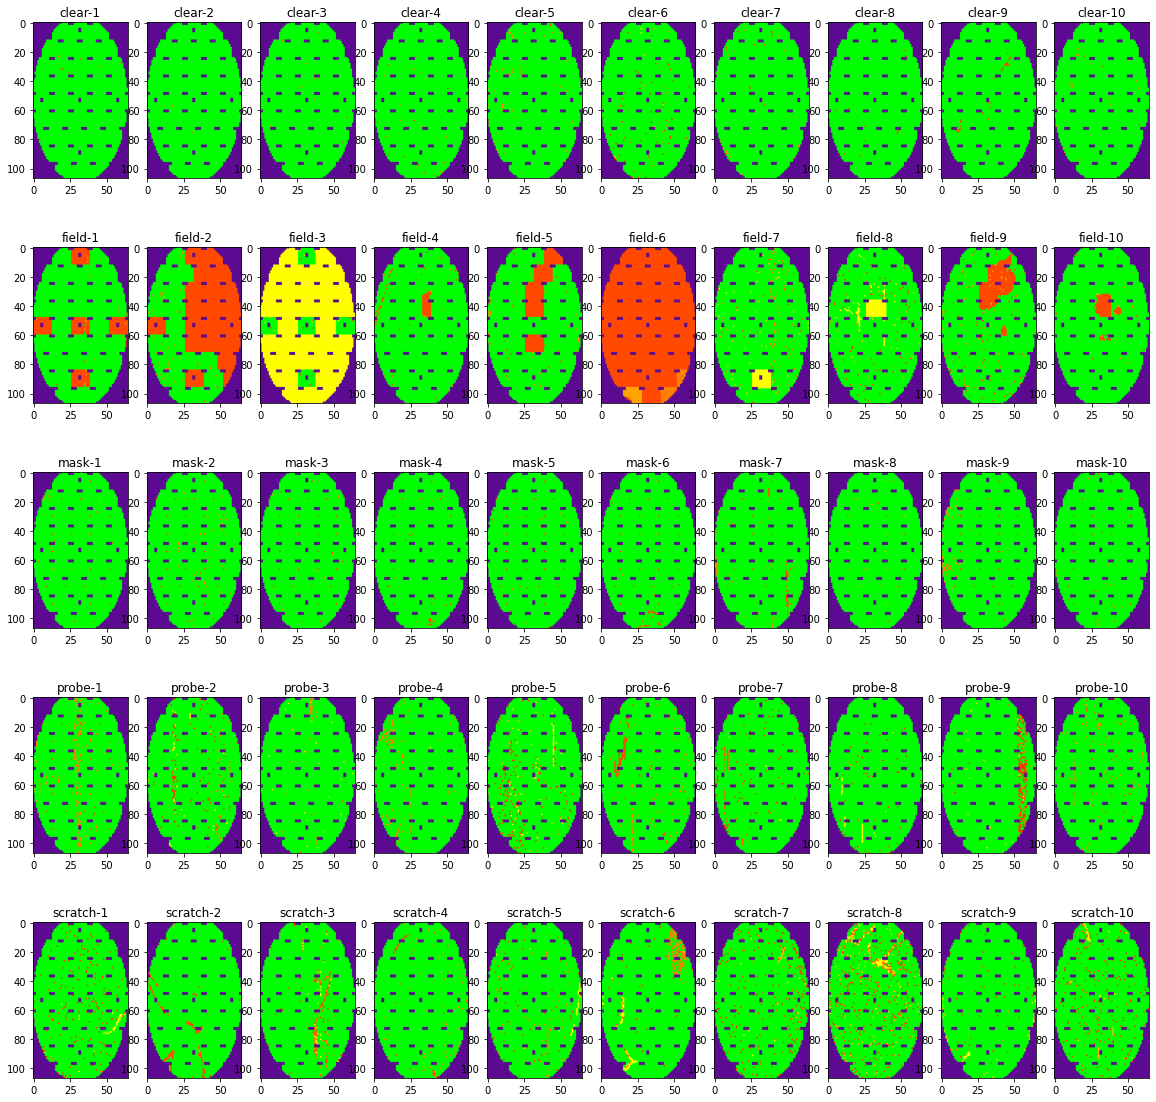

In [44]:
fig, ax = plt.subplots(nrows=len(categories), ncols=limit, figsize=(20, 20))
for i, category in enumerate(categories):
    for j in range(limit):
        ax[i, j].set_title(f"{category}-{j + 1}")
        ax[i, j].imshow(imgs_by_categories[category][j])

### Transforming the data into the form suitable for ML models

In [45]:
imgs_by_categories = {category: [] for category in dfs_by_categories.keys()}
for category, dfs in dfs_by_categories.items():
    imgs_by_categories[category] = [transform_csv_to_np(df) for df in dfs]

#### Balancing the dataset
As shown above, the dataset is heavily imbalanced. I'll balance using under-sampling, over-sampling and traditional data augmentation techniques with respect to the domain specificity (uniform elliptical shape of the wafer bin map). Classes will be treated differently because of different numbers of samples.

- `clear` (9999 samples) -> will be randomly under-sampled to approximately 2000 samples
- `field` ( 368 samples) -> will be flipped up-down and left-right creating 4 * 368 = 1472 images. After that, a random over-sampling will be used to get approximately 2000 samples
- `mask` (2897 samples) -> will be randomly under-sampled to approximately 2000 samples
- `probe` (1080 samples) -> will be randomly flipped up-down and left-right to obtain approximately 2000 samples
- `scratch` ( 129 samples) -> will be flipped up-down and left-right creating 4 * 129 = 516 images. After that, a random over-sampling will be used to get approximately 2000 samples

In [46]:
def resample(list_, res_samples):
    return [random.choice(list_) for _ in range(res_samples)]

In [47]:
def resize_image_square(img, final_size=128, color=-1):
    delta_w = final_size - img.shape[1]
    delta_h = final_size - img.shape[0]
    
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    return cv2.copyMakeBorder(img.T, left, right, top, bottom, cv2.BORDER_CONSTANT, value=color).T

In [48]:
flipping_functions = [np.fliplr, np.flipud]
categories_to_flip = ["field", "scratch"]

for category in categories_to_flip:
    for flipping_function in flipping_functions:
        imgs_by_categories[category] += [flipping_function(img) for img in imgs_by_categories[category]]

In [49]:
imgs_by_categories["probe"] += [np.fliplr(img) for img in random.sample(imgs_by_categories["probe"], int(len(imgs_by_categories["probe"]) * 0.36))]
imgs_by_categories["probe"] += [np.flipud(img) for img in random.sample(imgs_by_categories["probe"], int(len(imgs_by_categories["probe"]) * 0.36))] 

In [50]:
# under-sampling
imgs_by_categories["clear"] = resample(imgs_by_categories["clear"], 2000)
imgs_by_categories["mask"] = resample(imgs_by_categories["mask"], 2000)

# over-sampling
imgs_by_categories["field"] = resample(imgs_by_categories["field"], 2000)
imgs_by_categories["scratch"] = resample(imgs_by_categories["scratch"], 2000)


Now, the dataset should be balanced.

In [51]:
for category, imgs in imgs_by_categories.items():
    print(f"{category:7} - {len(imgs)} samples")

clear   - 2000 samples
field   - 2000 samples
mask    - 2000 samples
probe   - 1996 samples
scratch - 2000 samples


In [52]:
def get_x_y_by_categories(categories, data_by_categories):
    if categories == [] or categories == [-1] or categories == None:
        categories = data_by_categories.keys()
        
    X, y = [], []
    for category in categories:
        X += data_by_categories[category]
        y += [category] * len(data_by_categories[category])
    return np.array(X), np.array(y)

## Data augmentation with GANs

Souce: [TensorFlow](https://www.tensorflow.org/tutorials/generative/dcgan)

A GAN (Generative Adversarial Network) is composed of two models - a **generator** which learns to create images that look real and a **discriminator** that learns to decide whether the image is real or fake.

During training, the generator becomes better at creating images that look real while discriminator becomes better at telling them apart. The process reaches the (Nash) equilibrium when the discriminator can no longer distinguish real images from fakes.

### Generator and discriminator

In [53]:
noise_dim = 2000

In [54]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 128, 128, 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.Activation('tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

In [55]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [56]:
generator = make_generator_model()
discriminator = make_discriminator_model()

### Loss and optimizers

In [57]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [58]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [59]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [60]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Checkpoint

In [61]:
checkpoint_dir = "/kaggle/working/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

### Training loop

In [62]:
epochs_gan = 100
batch_size = 256
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [63]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step(images, gen_losses, disc_losses):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_losses, disc_losses

In [64]:
def generate_images(model, epoch, test_input):
    # training is set to False so all layers run in inference mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis("off")

    plt.show()

In [65]:
def plot_losses(gen_losses, disc_losses):
    x = list(range(len(gen_losses)))
    plt.plot(x, gen_losses, color="blue", label="Generator loss")
    plt.plot(x, disc_losses, color="orange", label="Discriminator loss")
    plt.legend()
    plt.show()
    

In [66]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        start = time.time()
        gen_losses, disc_losses = [], []

        for i, image_batch in enumerate(dataset):
            gen_losses, disc_losses = train_step(image_batch, gen_losses, disc_losses)

        print(f"  Average generator loss: {np.mean(gen_losses):.4f}, average discriminator loss: {np.mean(disc_losses):.4f}.")
        # plot_losses(gen_losses, disc_losses)
        if epoch % 10 == 0:
            generate_images(generator, epoch + 1, seed)
        # checkpoint.save(file_prefix=checkpoint_prefix)

        print (f"  Computation time: {(time.time()-start):.4f} seconds")

### Data preparation
GAN will be trained only on defective classes.

In [67]:
X, y = get_x_y_by_categories(["field", "mask", "probe", "scratch"], imgs_by_categories)

X = [resize_image_square(x) for x in X]

enc = OneHotEncoder(sparse=False)
enc.fit(np.array(categories).reshape(-1, 1))
y = enc.transform(y.reshape(-1, 1))

scaler = MinMaxScaler()
_ = [scaler.partial_fit(x) for x in X] 

X = np.array([scaler.transform(x) for x in X])

X, y = shuffle(X, y, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED, shuffle=True)

### Train GAN
After first iteration and after every tenth iteration after that, 16 generated images will be displayed.

2021-11-30 22:34:25.763226: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1048051712 exceeds 10% of free system memory.


Epoch 1/100
  Average generator loss: 2.2120, average discriminator loss: 0.7676.


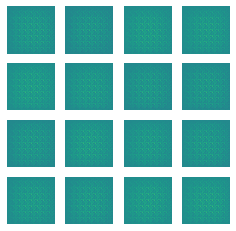

  Computation time: 11.9336 seconds
Epoch 2/100
  Average generator loss: 3.1847, average discriminator loss: 0.2427.
  Computation time: 11.2645 seconds
Epoch 3/100
  Average generator loss: 2.6890, average discriminator loss: 0.3188.
  Computation time: 11.2004 seconds
Epoch 4/100
  Average generator loss: 3.0514, average discriminator loss: 0.3197.
  Computation time: 11.1905 seconds
Epoch 5/100
  Average generator loss: 4.4120, average discriminator loss: 0.1666.
  Computation time: 11.2535 seconds
Epoch 6/100
  Average generator loss: 3.2491, average discriminator loss: 0.2817.
  Computation time: 11.1832 seconds
Epoch 7/100
  Average generator loss: 3.3821, average discriminator loss: 0.3284.
  Computation time: 11.1858 seconds
Epoch 8/100
  Average generator loss: 2.5421, average discriminator loss: 0.3541.
  Computation time: 11.2301 seconds
Epoch 9/100
  Average generator loss: 2.5980, average discriminator loss: 0.3962.
  Computation time: 11.1921 seconds
Epoch 10/100
  Avera

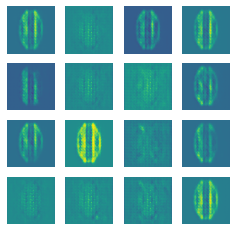

  Computation time: 11.9021 seconds
Epoch 12/100
  Average generator loss: 2.2959, average discriminator loss: 0.3655.
  Computation time: 11.2029 seconds
Epoch 13/100
  Average generator loss: 2.4275, average discriminator loss: 0.3209.
  Computation time: 11.2264 seconds
Epoch 14/100
  Average generator loss: 2.5988, average discriminator loss: 0.2599.
  Computation time: 11.2368 seconds
Epoch 15/100
  Average generator loss: 2.7735, average discriminator loss: 0.2189.
  Computation time: 11.2098 seconds
Epoch 16/100
  Average generator loss: 2.7587, average discriminator loss: 0.2485.
  Computation time: 11.2060 seconds
Epoch 17/100
  Average generator loss: 3.0009, average discriminator loss: 0.2292.
  Computation time: 11.2946 seconds
Epoch 18/100
  Average generator loss: 3.0695, average discriminator loss: 0.2192.
  Computation time: 11.1813 seconds
Epoch 19/100
  Average generator loss: 3.1668, average discriminator loss: 0.1923.
  Computation time: 11.1746 seconds
Epoch 20/100

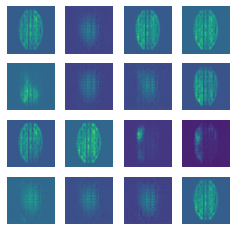

  Computation time: 11.7948 seconds
Epoch 22/100
  Average generator loss: 3.7519, average discriminator loss: 0.1746.
  Computation time: 11.1950 seconds
Epoch 23/100
  Average generator loss: 3.6875, average discriminator loss: 0.1719.
  Computation time: 11.3377 seconds
Epoch 24/100
  Average generator loss: 3.5875, average discriminator loss: 0.1574.
  Computation time: 11.1859 seconds
Epoch 25/100
  Average generator loss: 3.1925, average discriminator loss: 0.1632.
  Computation time: 11.1913 seconds
Epoch 26/100
  Average generator loss: 3.1769, average discriminator loss: 0.1486.
  Computation time: 11.3187 seconds
Epoch 27/100
  Average generator loss: 3.1723, average discriminator loss: 0.1559.
  Computation time: 11.2310 seconds
Epoch 28/100
  Average generator loss: 3.2113, average discriminator loss: 0.1437.
  Computation time: 11.2133 seconds
Epoch 29/100
  Average generator loss: 3.0157, average discriminator loss: 0.1654.
  Computation time: 11.3514 seconds
Epoch 30/100

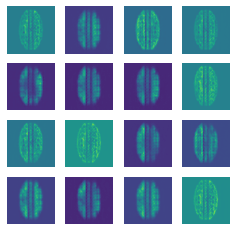

  Computation time: 11.9733 seconds
Epoch 32/100
  Average generator loss: 2.9871, average discriminator loss: 0.1630.
  Computation time: 11.7121 seconds
Epoch 33/100
  Average generator loss: 2.9669, average discriminator loss: 0.1579.
  Computation time: 11.2143 seconds
Epoch 34/100
  Average generator loss: 3.1557, average discriminator loss: 0.1450.
  Computation time: 11.3738 seconds
Epoch 35/100
  Average generator loss: 3.5444, average discriminator loss: 0.1102.
  Computation time: 11.1920 seconds
Epoch 36/100
  Average generator loss: 3.3910, average discriminator loss: 0.1504.
  Computation time: 11.1844 seconds
Epoch 37/100
  Average generator loss: 3.3435, average discriminator loss: 0.1749.
  Computation time: 11.3513 seconds
Epoch 38/100
  Average generator loss: 3.1640, average discriminator loss: 0.1365.
  Computation time: 11.1816 seconds
Epoch 39/100
  Average generator loss: 3.3832, average discriminator loss: 0.1153.
  Computation time: 11.1826 seconds
Epoch 40/100

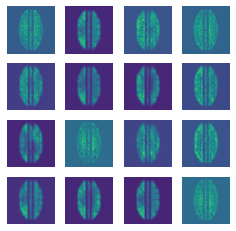

  Computation time: 11.8103 seconds
Epoch 42/100
  Average generator loss: 3.7187, average discriminator loss: 0.0903.
  Computation time: 11.2041 seconds
Epoch 43/100
  Average generator loss: 3.2417, average discriminator loss: 0.1266.
  Computation time: 11.2988 seconds
Epoch 44/100
  Average generator loss: 3.5823, average discriminator loss: 0.1078.
  Computation time: 11.2118 seconds
Epoch 45/100
  Average generator loss: 3.4771, average discriminator loss: 0.1028.
  Computation time: 11.1946 seconds
Epoch 46/100
  Average generator loss: 3.6363, average discriminator loss: 0.0997.
  Computation time: 11.3494 seconds
Epoch 47/100
  Average generator loss: 3.8649, average discriminator loss: 0.0919.
  Computation time: 11.2043 seconds
Epoch 48/100
  Average generator loss: 3.2180, average discriminator loss: 0.2940.
  Computation time: 11.1923 seconds
Epoch 49/100
  Average generator loss: 3.2444, average discriminator loss: 0.1703.
  Computation time: 11.2632 seconds
Epoch 50/100

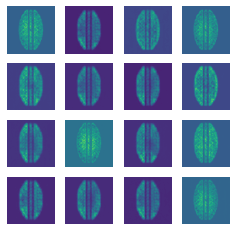

  Computation time: 11.7930 seconds
Epoch 52/100
  Average generator loss: 3.4489, average discriminator loss: 0.1035.
  Computation time: 11.2354 seconds
Epoch 53/100
  Average generator loss: 3.5192, average discriminator loss: 0.1094.
  Computation time: 11.1891 seconds
Epoch 54/100
  Average generator loss: 3.8743, average discriminator loss: 0.1163.
  Computation time: 11.1940 seconds
Epoch 55/100
  Average generator loss: 3.7172, average discriminator loss: 0.0941.
  Computation time: 11.2428 seconds
Epoch 56/100
  Average generator loss: 3.5647, average discriminator loss: 0.0922.
  Computation time: 11.1749 seconds
Epoch 57/100
  Average generator loss: 3.9321, average discriminator loss: 0.0880.
  Computation time: 21.0886 seconds
Epoch 58/100
  Average generator loss: 3.6770, average discriminator loss: 0.0866.
  Computation time: 11.1925 seconds
Epoch 59/100
  Average generator loss: 3.7080, average discriminator loss: 0.0947.
  Computation time: 21.0907 seconds
Epoch 60/100

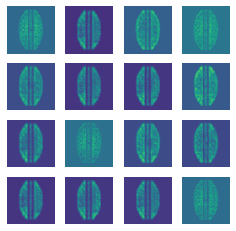

  Computation time: 22.1737 seconds
Epoch 62/100
  Average generator loss: 3.8728, average discriminator loss: 0.1234.
  Computation time: 11.2501 seconds
Epoch 63/100
  Average generator loss: 3.4120, average discriminator loss: 0.2994.
  Computation time: 11.2818 seconds
Epoch 64/100
  Average generator loss: 3.2245, average discriminator loss: 0.1407.
  Computation time: 11.2371 seconds
Epoch 65/100
  Average generator loss: 3.7565, average discriminator loss: 0.0872.
  Computation time: 11.2038 seconds
Epoch 66/100
  Average generator loss: 4.4795, average discriminator loss: 0.0555.
  Computation time: 11.2699 seconds
Epoch 67/100
  Average generator loss: 4.7298, average discriminator loss: 0.0595.
  Computation time: 11.1893 seconds
Epoch 68/100
  Average generator loss: 5.0408, average discriminator loss: 0.0476.
  Computation time: 11.1689 seconds
Epoch 69/100
  Average generator loss: 4.3128, average discriminator loss: 0.0686.
  Computation time: 11.3023 seconds
Epoch 70/100

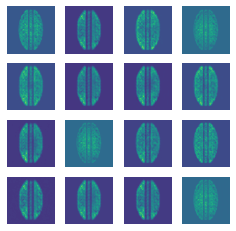

  Computation time: 11.8032 seconds
Epoch 72/100
  Average generator loss: 4.0454, average discriminator loss: 0.0762.
  Computation time: 11.2394 seconds
Epoch 73/100
  Average generator loss: 4.5558, average discriminator loss: 0.0567.
  Computation time: 11.2210 seconds
Epoch 74/100
  Average generator loss: 3.9753, average discriminator loss: 0.0750.
  Computation time: 11.1740 seconds
Epoch 75/100
  Average generator loss: 4.8448, average discriminator loss: 0.0545.
  Computation time: 11.2220 seconds
Epoch 76/100
  Average generator loss: 4.1178, average discriminator loss: 0.1037.
  Computation time: 11.2086 seconds
Epoch 77/100
  Average generator loss: 3.6169, average discriminator loss: 0.1146.
  Computation time: 11.1943 seconds
Epoch 78/100
  Average generator loss: 3.9739, average discriminator loss: 0.0699.
  Computation time: 11.3360 seconds
Epoch 79/100
  Average generator loss: 4.3352, average discriminator loss: 0.0635.
  Computation time: 21.2254 seconds
Epoch 80/100

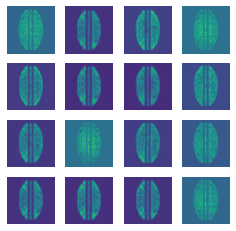

  Computation time: 11.9780 seconds
Epoch 82/100
  Average generator loss: 4.3288, average discriminator loss: 0.0924.
  Computation time: 11.3466 seconds
Epoch 83/100
  Average generator loss: 3.4179, average discriminator loss: 0.6370.
  Computation time: 11.4206 seconds
Epoch 84/100
  Average generator loss: 3.0060, average discriminator loss: 0.2570.
  Computation time: 11.2075 seconds
Epoch 85/100
  Average generator loss: 3.3931, average discriminator loss: 0.1268.
  Computation time: 11.3030 seconds
Epoch 86/100
  Average generator loss: 4.9524, average discriminator loss: 0.0676.
  Computation time: 11.1933 seconds
Epoch 87/100
  Average generator loss: 3.6840, average discriminator loss: 0.1141.
  Computation time: 11.2423 seconds
Epoch 88/100
  Average generator loss: 4.1096, average discriminator loss: 0.0731.
  Computation time: 11.2967 seconds
Epoch 89/100
  Average generator loss: 4.4662, average discriminator loss: 0.0704.
  Computation time: 11.1851 seconds
Epoch 90/100

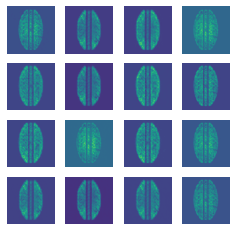

  Computation time: 11.8450 seconds
Epoch 92/100
  Average generator loss: 4.6281, average discriminator loss: 0.0533.
  Computation time: 11.1988 seconds
Epoch 93/100
  Average generator loss: 4.3782, average discriminator loss: 0.0826.
  Computation time: 11.1658 seconds
Epoch 94/100
  Average generator loss: 3.9749, average discriminator loss: 0.0791.
  Computation time: 11.2068 seconds
Epoch 95/100
  Average generator loss: 4.3182, average discriminator loss: 0.0553.
  Computation time: 11.1769 seconds
Epoch 96/100
  Average generator loss: 3.7458, average discriminator loss: 0.0908.
  Computation time: 11.1882 seconds
Epoch 97/100
  Average generator loss: 4.1091, average discriminator loss: 0.1063.
  Computation time: 11.2505 seconds
Epoch 98/100
  Average generator loss: 3.6934, average discriminator loss: 0.1170.
  Computation time: 11.2023 seconds
Epoch 99/100
  Average generator loss: 4.0887, average discriminator loss: 0.1320.
  Computation time: 11.1711 seconds
Epoch 100/10

In [68]:
X_reshaped = X.reshape(-1, 128, 128, 1)
X_batched = tf.data.Dataset.from_tensor_slices(X_reshaped).batch(BATCH_SIZE)
train(X_batched, epochs_gan)

In [69]:
def transform_generated_to_img(generated):
    generated = scaler.inverse_transform(generated)
    img = np.zeros((generated.shape[0], generated.shape[1], 3), dtype=int)
    for x in range(generated.shape[0]):
        for y in range(generated.shape[1]):
            img[x, y, 0], img[x, y, 1], img[x, y, 2] = get_color(generated[x, y])
    return img

### GAN's output

#### Display 20 artificially generated images
Images are displayer in two lines. First line consists of images from generator, the second line consists of these images with custom wafer bin map color map applied.

In [70]:
noise = tf.random.normal([1, 2000])

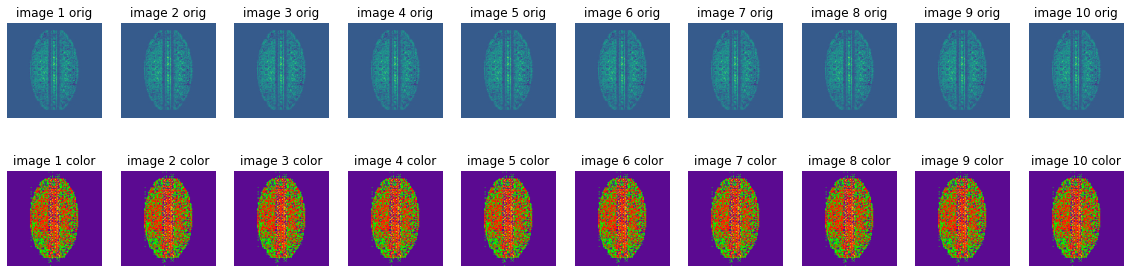

In [71]:
nrows = 2
ncols = 10
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5))
for j in range(ncols):
    img_original = generator(noise, training=False)
    img_colormap = transform_generated_to_img(img_original[0, :, :, 0])
    for i in range(nrows):
        title = "orig" if i == 0 else "color"
        img = img_original[0, :, :, 0] if i == 0 else img_colormap
        ax[i, j].set_title(f"image {j + 1} {title}")
        ax[i, j].imshow(img)
        ax[i, j].axis("off")
plt.show()

## Wafer bin maps classification using CNN

### Define model

In [72]:
def make_classification_model(num_classes, batch_size):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, 5, activation="relu", input_shape=(128, 128, 1)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 5, activation="relu"))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dropout(0.15))
    model.add(layers.Dense(num_classes))
    model.add(layers.Softmax())
    return model

In [73]:
classification_model = make_classification_model(len(categories), 256)
classification_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

- early stopping: stop training if the validation accuracy hasn't been improved for the last 10 epochs
- model checkpoint: save model only if the validation accuracy has been improved

In [74]:
early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=10)
model_checkpoint = ModelCheckpoint("best_model", monitor="val_accuracy", mode="max", verbose=1, save_best_only=True)

### Train model

Classification model will be trained on a balanced dataset with all classes.

In [75]:
X, y = get_x_y_by_categories([-1], imgs_by_categories)

X = [resize_image_square(x) for x in X]

enc = OneHotEncoder(sparse=False)
enc.fit(np.array(categories).reshape(-1, 1))
y = enc.transform(y.reshape(-1, 1))

scaler = MinMaxScaler()
_ = [scaler.partial_fit(x) for x in X] 
X = np.array([scaler.transform(x) for x in X])

X, y = shuffle(X, y, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED, shuffle=True)

In [76]:
X_train_reshaped = X_train.reshape(-1, 128, 128, 1)
X_test_reshaped = X_test.reshape(-1, 128, 128, 1)
history = classification_model.fit(x=X_train_reshaped, y=y_train, epochs=50, verbose=2, callbacks=[early_stopping, model_checkpoint], validation_data=(X_test_reshaped, y_test))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
2021-11-30 22:54:10.349213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
250/250 - 5s - loss: 0.8723 - accuracy: 0.6588 - val_loss: 0.5204 - val_accuracy: 0.7985

Epoch 00001: val_accuracy improved from -inf to 0.79850, saving model to best_model


2021-11-30 22:54:16.192418: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/50
250/250 - 5s - loss: 0.3916 - accuracy: 0.8624 - val_loss: 0.3401 - val_accuracy: 0.8820

Epoch 00002: val_accuracy improved from 0.79850 to 0.88200, saving model to best_model
Epoch 3/50
250/250 - 5s - loss: 0.2624 - accuracy: 0.9163 - val_loss: 0.2933 - val_accuracy: 0.9045

Epoch 00003: val_accuracy improved from 0.88200 to 0.90450, saving model to best_model
Epoch 4/50
250/250 - 5s - loss: 0.1882 - accuracy: 0.9442 - val_loss: 0.2604 - val_accuracy: 0.9185

Epoch 00004: val_accuracy improved from 0.90450 to 0.91850, saving model to best_model
Epoch 5/50
250/250 - 5s - loss: 0.1379 - accuracy: 0.9601 - val_loss: 0.2369 - val_accuracy: 0.9290

Epoch 00005: val_accuracy improved from 0.91850 to 0.92900, saving model to best_model
Epoch 6/50
250/250 - 5s - loss: 0.1085 - accuracy: 0.9694 - val_loss: 0.2291 - val_accuracy: 0.9220

Epoch 00006: val_accuracy did not improve from 0.92900
Epoch 7/50
250/250 - 5s - loss: 0.1066 - accuracy: 0.9697 - val_loss: 0.2350 - val_accuracy:

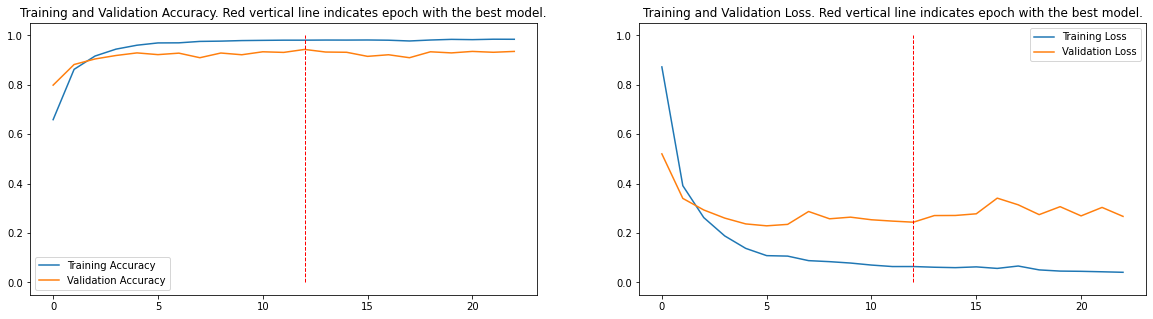

In [77]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]
best_val_loss_idx = np.argmax(val_accuracy)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax[0].plot(range(len(accuracy)), accuracy, label="Training Accuracy")
ax[0].plot(range(len(accuracy)), val_accuracy, label="Validation Accuracy")
ax[0].plot([best_val_loss_idx, best_val_loss_idx], [0, 1], "r--", lw=1)
ax[0].set_title("Training and Validation Accuracy. Red vertical line indicates epoch with the best model.")
ax[0].legend()

ax[1].plot(range(len(accuracy)), loss, label="Training Loss")
ax[1].plot(range(len(accuracy)), val_loss, label="Validation Loss")
ax[1].plot([best_val_loss_idx, best_val_loss_idx], [0, 1], "r--", lw=1)
ax[1].set_title("Training and Validation Loss. Red vertical line indicates epoch with the best model.")
ax[1].legend()
plt.show()

### Classification's model output
Source: [Tensorflow](https://www.tensorflow.org/tutorials/keras/classification)

In [78]:
def plot_image(i, predictions_array, true_labels, imgs):
    true_label, img = true_labels[i][0], imgs[i]
    img = img.reshape(*img.shape[:2])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(transform_generated_to_img(img))

    predicted_label = categories[np.argmax(predictions_array)]
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel(f"{predicted_label} {100*np.max(predictions_array):2.0f}% ({true_label})", color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(len(predictions_array)))
    plt.yticks([])
    thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[categories.index(true_label)].set_color('blue')

In [79]:
model = tf.keras.models.load_model('best_model')
test_images = X_test_reshaped[:15]
test_labels = enc.inverse_transform(y_test)[:15]
predictions = model.predict(test_images)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Displays validation images and a graph indicating distribution of softmax probabilities that the image belong to the respective class. First, a predicted label is displayed folowed by the model's certainty and a ground-truth label. If the sample has been misclassified, the title is red, otherwise it's blue.

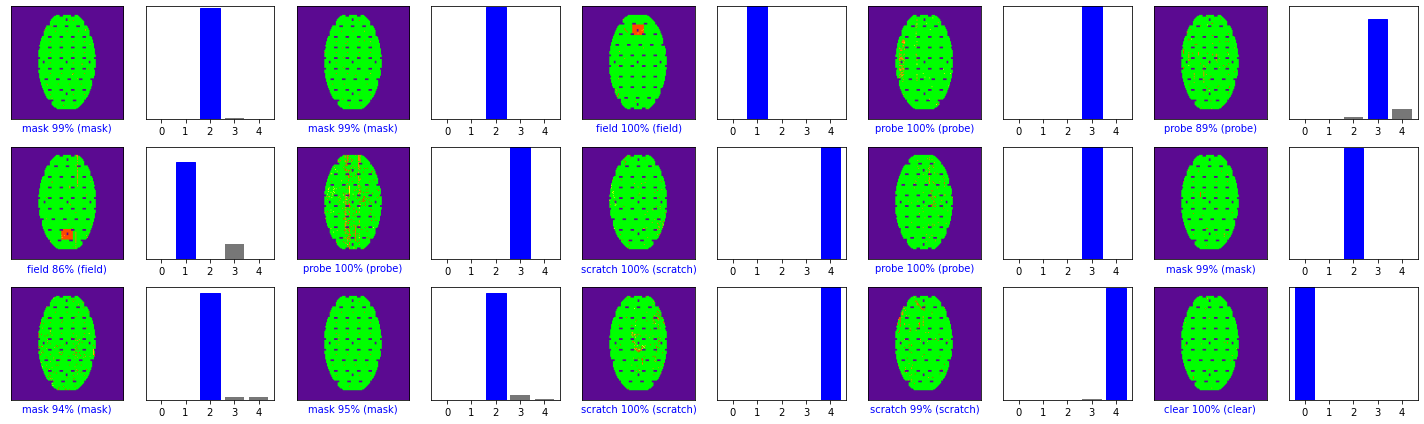

In [80]:
num_rows = 3
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()